In [ ]:
%pip install qiskit
%pip install qiskit-ibm-runtime
%pip install qiskit-ibm-transpiler
%pip install qiskit-ibm-catalog
%pip install qiskit-addon-utils
%pip install qiskit-serverless
%pip install qiskit-addon-sqd
%pip install qiskit-addon-obp
# %pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git

# Exploring Qiskit addons

### Laying the groundwork for a quantum applications ecosystem

The functions catalog contains abstracted services that handle multiple stages of a quantum workflow. In this next section, we'll explore Qiskit addons: a collection of modular research capabilities for enabling algorithm discovery at the utility scale. Qiskit addons address particular tasks within a stage of a larger quantum workflow (like Qiskit patterns) to scale or design new algorithms. These tools set the stage for users to release functions and workflows of their own in the quantum applications ecosystem.

## Qiskit addons

While Qiskit functions provide core capabilities to streamline quantum circuits and domain-specific problems, Qiskit addons take functions a step further by offering specialized tools to tackle nuanced problems. While Qiskit functions simplify and streamline workflows, Qiskit addons customize and enhance experiments to enable efficient utility-scale workloads.

| Add-On | Description | Example |
|---|---|---|
| Multi-product formulas (MPF)           | Reduces Trotter errors for time evolution problems, which often require deep circuits. MPF combines experiments with different Trotter errors to produce an estimate with a lower overall Trotter error.                                                             | 50 qubits with 27 2q-depth            |
| Approximate quantum compilation (AQC-Tensor) | Constructs circuits with reduced depth for time evolution problems. Uses tensor networks to compress initial circuit layers, allowing more depth for further evolution time; beneficial as classical tractability diminishes with longer times.                   | 50 qubits with 27 2q-depth            |
| Operator backpropagation (OBP)         | Reduces circuit depth at the expense of more operator measurements. Especially useful for circuits like Trotterized time-evolution, which get deeper and closer to Clifford gates with increased accuracy, thus reducing the impact of noise.                   | 127 qubits with 82 2q-depths          |
| Sample-based quantum diagonalization (SQD) | Produces more accurate eigenvalue estimations from noisy quantum samples. SQD uses classical distributed computing to refine noisy samples, aiding energy estimation for large Hamiltonians, which are otherwise limited by circuit depth and error mitigation costs. | 77-q chemistry Hamiltonian with 3590 CNOTs |







# Exploring Operator Backpropagation (OBP) - Challenge

### **Motivation:**

Experimental errors limit the depth of quantum circuits that can be executed on near-term devices. Operator backpropagation is a technique that involves absorbing operations from the end of a quantum circuit into a Pauli operator, generally reducing the depth of the circuit at the cost of additional terms in the operator. The goal is to backpropagate as much of the circuit as possible without allowing the operator to grow too large.

One way to allow for deeper backpropagation into the circuit, while preventing the operator from growing too large, is to truncate terms with small coefficients rather than adding them to the operator. Truncating terms can result in fewer quantum circuits to execute, but doing so results in some error in the final expectation value calculation proportional to the magnitude of the truncated terms' coefficients. You can find the [OBP docs here](https://qiskit.github.io/qiskit-addon-obp/) and more on [Qiskit addon utils docs here](https://qiskit.github.io/qiskit-addon-utils/).



### Problem setup
First we load the Qiskit Runtime service and specify a backend. For information on setting up your Qiskit Runtime account locally, see the [guide](https://docs.quantum.ibm.com/guides/setup-channel).

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")

We now create a Pauli operator describing the quantum Heisenberg XY model. For this challenge, we will use a 133-site 2D Heisenberg model, which covers the entire Heron r1 QPU, ``ibm_torino``. For details on this Hamiltonian, see the [API docs](https://qiskit.github.io/qiskit-addon-utils/stubs/qiskit_addon_utils.problem_generators.generate_xyz_hamiltonian.html#qiskit_addon_utils.problem_generators.generate_xyz_hamiltonian).

In [2]:
import numpy as np
from qiskit_addon_utils.problem_generators import generate_xyz_hamiltonian
from qiskit_addon_utils.coloring import auto_color_edges

# Color the edges s.t. the operator terms are ordered for hardware efficiency
coupling_map = backend.coupling_map
edges = set(coupling_map.get_edges())
unique_edges = set()
for edge in edges:
    if edge[::-1] not in unique_edges:
        unique_edges.add(edge)
coloring = auto_color_edges(sorted(unique_edges))

# Get a qubit operator describing the Heisenberg XY model
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants=(1.0, 1.0, 0.0),
    coloring=coloring,
)

Next, we will generate a quantum circuit describing the time evolution of the XY model. We will model the time evolution of the system for ``time`` = ``0.5`` units of time over ``10`` Trotter steps.

In [3]:
from qiskit.synthesis import LieTrotter
from qiskit_addon_utils.problem_generators import generate_time_evolution_circuit

dt = 0.05
reps = 10
time = dt * reps  # total time = 0.5 = dt * reps

circuit = generate_time_evolution_circuit(
    hamiltonian,
    time=time,
    synthesis=LieTrotter(reps=reps),
)
print(f"Circuit depth: {circuit.depth()}")
# circuit.draw("mpl", fold=-1)

Circuit depth: 60


Specify the observable we wish to evaluate. For simplicity, we will measure the magnetization of a single site in the middle of the chain.

In [4]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp.from_sparse_list([("Z", [(circuit.num_qubits)//2], 1.0) ],num_qubits=circuit.num_qubits)
observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])

Next, we create the slices required by the `backpropagate` function. Here we will slice by gate type, so each slice is guaranteed to only contain instances of a single gate type.

In [5]:
from qiskit_addon_utils.slicing import slice_by_gate_types

slices = slice_by_gate_types(circuit)
print(
    f"The circuit has depth {circuit.depth()}, and it was split into {len(slices)} slices."
)

The circuit has depth 60, and it was split into 60 slices.


Here we limit the amount of truncation error challenge participants may incur to ``max_error_total`` = ``.05``. By using this error budget wisely, you can backpropagate deeper into the circuit.

We also cap the number of qubit-wise commuting Pauli groups the operator may hold at ``max_qwc_groups`` = ``20``. Once a slice is backpropagated that would cause the observable to be too large, the `backpropagate` function will return the results from the previous iteration.

In [6]:
max_error_total = 0.05
max_qwc_groups = 20

By distributing the ``.05`` budget cleverly, you can improve the performance. Here we set ``num_bp_slices`` = ``6``, indicating we want to attempt to backpropagate one whole Trotter step. We set ``max_error_per_slice`` = ``[0., ...]``, indicating we want to do no truncation.

**You should update the number of slices you want to attempt to backpropagate as you want to try to go deeper into the circuit.**

**You should allocate the ``.05`` error budget amongst the slices in any way you wish to try and improve performance.**

One strategy for truncation is to make the entire budget available to the last slice (remember we start backpropagating from the end of the circuit) and allow the algorithm to greedily consume the budget at each iteration as quickly as possible. One could also distribute the budget evenly among the slices you want to backpropagate. There are an uncountably infinite number of ways to distribute the error budget, so we encourage you to check out the [how-to guide](https://github.com/Qiskit/qiskit-addon-obp/blob/main/docs/how_tos/truncate_operator_terms.ipynb), then experiment with the values below and observe how they affect the performance of the technique.

<a id="exercise_1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1: Reduce circuit depth using OBP</b> 

This challenge involves using `qiskit-addon-obp` to reduce the depth of a quantum circuit while observing the following 2 constraints:
- The number of qubit-wise commuting Pauli groups in the observable may not grow larger than `20` during backpropagation
- The amount of truncation error incurred during backpropagation may not exceed `.05`

**Your task is to reduce the circuit depth as much as you can by adjusting the ``max_error_per_slice`` argument to the [setup_budget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.setup_budget.html#qiskit_addon_obp.utils.truncating.setup_budget) function.**

Challenge participants are expected to adjust how the `.05` truncation error budget is distributed among the slices to improve performance. Check out the [how-to on truncating](https://qiskit.github.io/qiskit-addon-obp/how_tos/truncate_operator_terms.html) for more details on distributing an error budget for backpropagation.
</div> 

In the code cell below, we show a simple example of setting `num_bp_slices` = `6`, indicating we want to attempt to backpropagate one whole Trotter step. We set `max_error_per_slice` = `[0., ...]`, indicating we want to do no truncation.

In [12]:
# Choose the number of slices to attempt to backpropagate.
# Each Trotter step is comprised of 6 slices.

### Write your code below here ###
num_bp_slices = 6

# Allocate the .05 error budget amongst the slices
max_error_per_slice = [0.0025] * num_bp_slices

### Don't change any code past this line ###

Now we'll set up our [TruncationErrorBudget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.truncating.TruncationErrorBudget.html) and [OperatorBudget](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.utils.simplify.OperatorBudget.html#qiskit_addon_obp.utils.simplify.OperatorBudget) objects to pass to [backpropagate](https://qiskit.github.io/qiskit-addon-obp/stubs/qiskit_addon_obp.backpropagate.html).

In [13]:
from qiskit_addon_obp.utils.truncating import TruncationErrorBudget, setup_budget
from qiskit_addon_obp.utils.simplify import OperatorBudget

error_budget = setup_budget(
    max_error_per_slice=max_error_per_slice, p_norm=2, max_error_total=max_error_total
)
op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)

Finally, we will call backpropagate and check the performance.

In [14]:
from qiskit_addon_obp import backpropagate
from qiskit_addon_utils.slicing import combine_slices

# Backpropagate slices onto the observable
bp_obs, remaining_slices, metadata = backpropagate(
    observable,
    slices[-num_bp_slices:],
    operator_budget=op_budget,
    truncation_error_budget=error_budget,
)
final_circ = combine_slices(slices[:-num_bp_slices] + remaining_slices)

print(
    f"Backpropagated {num_bp_slices - len(remaining_slices)} circuit slices, reducing the circuit depth from {circuit.depth()} to {final_circ.depth()} -- a reduction of {circuit.depth()-final_circ.depth()}."
)
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

Backpropagated 6 circuit slices, reducing the circuit depth from 60 to 54 -- a reduction of 6.
New observable contains 15 terms and 6 commuting groups.


Now that we've seen how the algorithm performed, we can visualize some of the metadata to see what happened at each iteration.

The **top/left** chart shows how much of the total budget was used by each slice. The **top/right** chart shows how unused budget is forwarded to deeper slices. The **bottom/left** chart shows how the error in our final calculation grows monotonically as we truncate more terms from the operator. The **bottom/right** chart shows of how many qubit-wise commuting Pauli groups the observable was comprised at each iteration. If the algorithm was returned due to the operator growing too large, this chart would show the number of groups exceeding the maximum in the final iteration.

/Users/vishalbajpe/opt/anaconda3/envs/qiskit-one/lib/python3.11/site-packages/qiskit_addon_obp/utils/visualization.py:400: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes.legend()


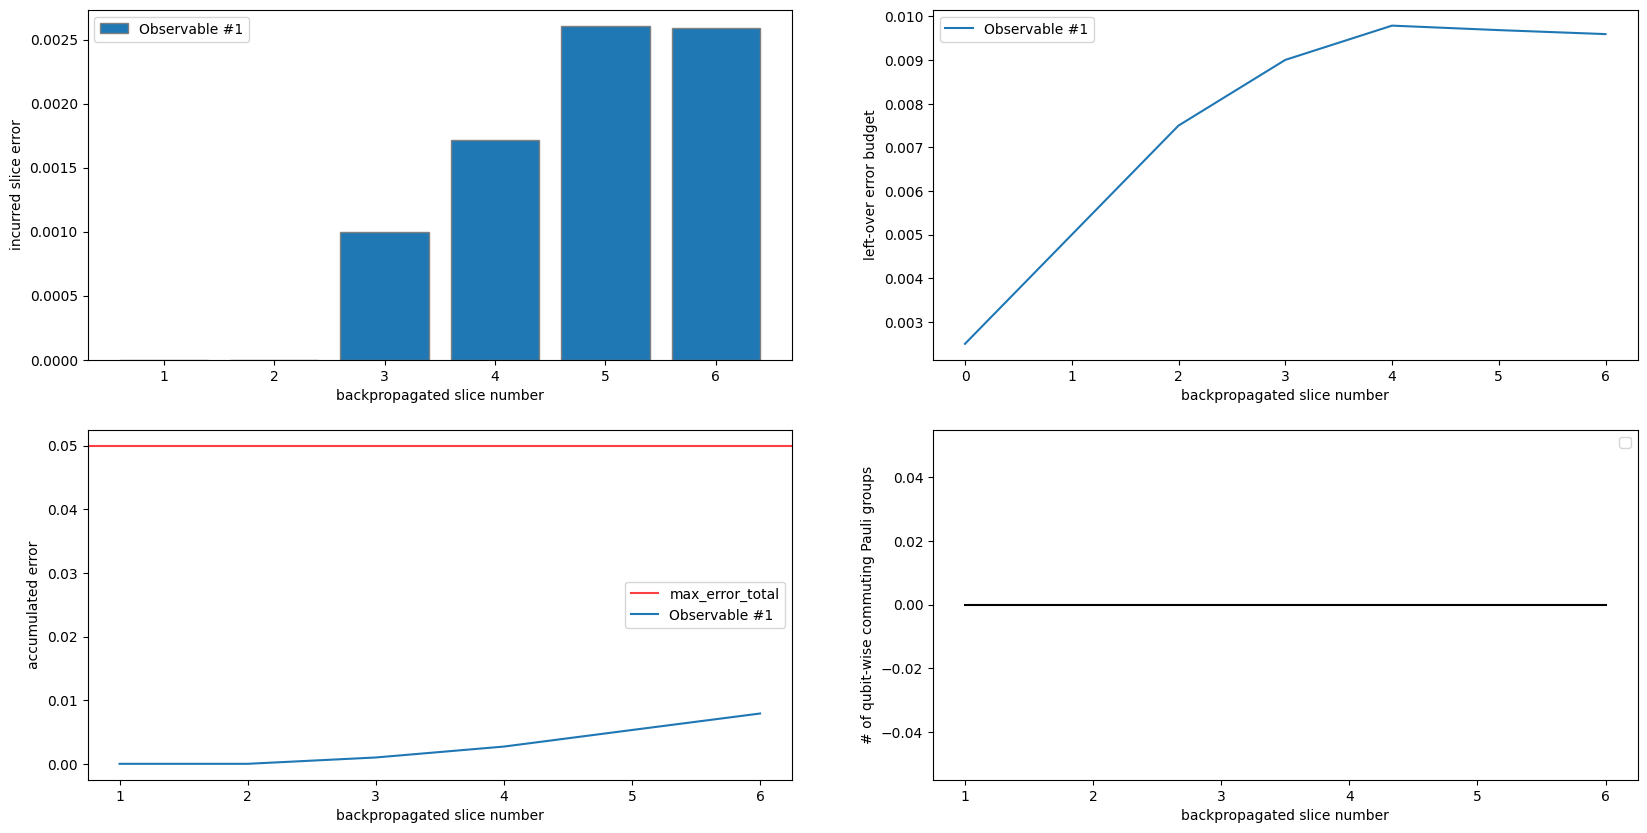

In [15]:
from matplotlib import pyplot as plt
from qiskit_addon_obp.utils.visualization import (
    plot_accumulated_error,
    plot_left_over_error_budget,
    plot_num_qwc_groups,
    plot_slice_errors,
)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))
plot_slice_errors(metadata, axes[(0, 0)])
plot_left_over_error_budget(metadata, axes[(0, 1)])
plot_accumulated_error(metadata, axes[(1, 0)])
plot_num_qwc_groups(metadata, axes[(1, 1)])

<div class="alert alert-block alert-info">
    <strong> Post-challenge note</strong><br><br>
    
For this challenge, we bound `max_qwc_groups` at ``20`` to ensure the operator would not grow too large during execution of the ``backpropagate`` and that it would execute quickly.

In practice, a numerical study for a given circuit is instructive in understanding how best to distribute the truncation budget. For example, as shown below, we can get a very strong result for this problem by allowing the operator to grow as large as needed until finally expending our entire budget on a single slice much deeper in the circuit.

You can see that while our observable grew very large while backpropagating these *30 slices* without truncation, the final size of the operator is still within our set constraints in the end, and we were able to backpropagate half of the circuit.
</div>

In [ ]:
# Allow the operator to grow as large as needed during backpropagation
max_qwc_groups = None
# Try to backpropagate 30 slices (5 Trotter steps)
num_bp_slices = 30
# Allocate all of the budget to the 30th slice
max_error_per_slice = [0.0] * (num_bp_slices - 1) + [max_error_total]

error_budget = setup_budget(
    max_error_per_slice=max_error_per_slice, p_norm=2, max_error_total=max_error_total
)
op_budget = OperatorBudget(max_qwc_groups=max_qwc_groups)

# Backpropagate slices onto the observable
bp_obs, remaining_slices, metadata = backpropagate(
    observable,
    slices[-num_bp_slices:],
    operator_budget=op_budget,
    truncation_error_budget=error_budget,
)
final_circ = combine_slices(slices[:-num_bp_slices] + remaining_slices)

print(
    f"Backpropagated {num_bp_slices - len(remaining_slices)} circuit slices, reducing the circuit depth from {circuit.depth()} to {final_circ.depth()} -- a reduction of {circuit.depth()-final_circ.depth()}."
)
print(
    f"New observable contains {len(bp_obs)} terms and {len(bp_obs.group_commuting(qubit_wise=True))} commuting groups."
)

# Additional information

**Created by:** Alejandra Perea Rojas, Bryce Fuller, Caleb Johnson, Javier Robledo Moreno, Jennifer Glick, Jim Garrison, Sanket Panda, Junye Huang, Max Rossmannek, Vishal Sharathchandra Bajpe

**Advised by:** Abby Mitchell, Blake Johnson, Henry Zou, Tushar Mittal

**Version:** 0.0.1